In [1]:
using Knet, LinearAlgebra, Random, SparseArrays, Printf, Statistics
using ScikitLearn
@sk_import svm: SVC

PyObject <class 'sklearn.svm.classes.SVC'>

In [2]:
mutable struct network_weights
    distance_parameter;
    input_dim;
    stride;
    NpS;
    output_dim;
    W;
    L;
    W_structure;
    L_structure;
    previous_NpS;
    lateral_distance;
end
    

In [3]:
function create_h_distances(n::network_weights)
    distances = zeros(n.output_dim^2, n.input_dim, n.input_dim)
    dict_input_2_position = Dict()
    for row_index in 1:n.input_dim
        for column_index in 1:n.input_dim
            input_index = row_index*n.input_dim + column_index
            dict_input_2_position[row_index, column_index] = input_index
    
        end
    end
    centers = []
    dict_output_2_position = Dict()
    for i in 1:n.output_dim
        for j in 1:n.output_dim
            stride_padding = n.stride/2
            neuron_center = [i*n.stride + stride_padding, j*n.stride + stride_padding]
            push!(centers,neuron_center)
            neuron_index = (i-1)*n.output_dim + j
            dict_output_2_position[neuron_index] = neuron_center
            for k in 1:n.input_dim
                 for l in 1:n.input_dim
                    #size issue here neuron index becomes 50 where it should be 49
                    distances[neuron_index, k,l] = norm([k+0.5,l+0.5]-neuron_center)
                 end
           end
        end
    end
    above_threshold = distances .> n.distance_parameter
    below_threshold = distances .<= n.distance_parameter
    distances[above_threshold] .= 0
    distances[below_threshold] .= 1
    distances = reshape(distances,(n.output_dim^2, n.input_dim^2))
    return distances
end

create_h_distances (generic function with 1 method)

In [4]:
function create_ah_distances(n::network_weights)
    centers = []
    dict_output_2_position = Dict()
    for i in 1:n.output_dim
        for j in 1:n.output_dim
            stride_padding = n.stride/2
            neuron_center = [(i-1)*n.stride + stride_padding, (j-1)*n.stride + stride_padding]
            push!(centers,neuron_center)
            neuron_index = (i-1)*n.output_dim + j
            dict_output_2_position[neuron_index] = neuron_center
        end
    end
    distances_ah = zeros(n.output_dim^2, n.output_dim^2)
    for row_index in keys(dict_output_2_position)
        center = dict_output_2_position[row_index]
        for column_index in keys(dict_output_2_position)
            other_center = dict_output_2_position[column_index]
            distances_ah[row_index, column_index] = norm(other_center - center)
        end
    end
    above_threshold = distances_ah .> n.lateral_distance #*self.anti_hebbian_binary
    below_threshold = distances_ah .<= n.lateral_distance #*self.anti_hebbian_binary
    distances_ah[above_threshold] .= 0
    distances_ah[below_threshold] .= 1
    return distances_ah
end    

create_ah_distances (generic function with 1 method)

In [5]:
function create_L(n::network_weights)
    #mat = n.create_ah_distances()
    mat = create_ah_distances(n)
    #blocks = [[mat]*n.NpS]*n.NpS
    L_mat = repeat(mat,n.NpS,n.NpS) ## !! Figure this one out
    return L_mat
end

function create_W(n::network_weights)
    #mat = n.create_ah_distances()
    mat = create_h_distances(n)
    #println("size of mat in create_h_distances")
    #println(size(mat))
    #blocks = [[mat]*n.previous_NpS]*n.NpS
    #println("n.previous_NpS")
    #println(n.previous_NpS)
    W_mat = repeat(mat,n.NpS,n.previous_NpS) ## !! Figure this one out
    return W_mat
end
    
    
function create_weights_matrix(n::network_weights)
    n.W_structure = create_W(n)
    n.L_structure = create_L(n)
    factor = sqrt(((sum(n.W_structure)/n.NpS)/(n.output_dim^2)))
    n.W = n.W_structure.*randn(size(n.W_structure))/factor
    n.L = n.L_structure.*Matrix{Float64}(I,n.NpS * n.output_dim^2,n.NpS * n.output_dim^2)
end

create_weights_matrix (generic function with 1 method)

In [6]:
function activation_function(vec)
    tanh.(vec)
end

activation_function (generic function with 1 method)

In [7]:
println(gpu()>=0)
if gpu() >= 0  # gpu() returns a device id >= 0 if there is a GPU, -1 otherwise 
    atype = KnetArray{Float32}  # KnetArrays are stored and operated in the GPU
end

true


KnetArray{Float32,N} where N

In [8]:
function convert_to_GPU(vec)
    vec=convert(atype,vec)
end

convert_to_GPU (generic function with 1 method)

In [9]:
mutable struct deep_network_GPU
    image_dim;
    channels;
    NpSs;
    strides;
    distances;
    lateral_distances;
    layers;
    gamma;
    lr;
    lr_floor;
    current_lr;
    decay;
    conversion_tickers;
    costs; 
    epoch;
    structure;
    deep_matrix_weights;
    deep_matrix_structure;
    deep_matrix_identity;
    weights_adjustment_matrix;
    weights_update_matrix;
    grad_matrix;
    n_images;
    dict_weights;
    dimensions; 
    g_vec;
    mult_vec;
    euler_step;
    tanh_factors;
    mult_factors;
    W_gpu;
end


In [10]:
function int(x)
convert(Int,floor(x))
end

int (generic function with 1 method)

In [11]:
function create_deep_network(dn::deep_network_GPU)
    for i in 1:dn.layers+1
        if i==1
            dim=1
        else
            dim = int(prod(dn.strides[1:i-1]))
        end
        push!(dn.dimensions,(int((dn.image_dim/dim)^2)*hcat([dn.channels],dn.NpSs)[i]))
    end

    for i in 1:dn.layers
        if i==1
            dim=1
        else
            dim = int(prod(dn.strides[1:i-1]))
        end
        layer_input_dim = int(dn.image_dim/dim)

         dn.dict_weights[i]=network_weights(dn.distances[i],layer_input_dim,dn.strides[i],hcat([dn.channels],dn.NpSs)[i+1],
         int(layer_input_dim/dn.strides[i]),[],[],
         [], [], hcat([dn.channels],dn.NpSs)[i], dn.lateral_distances[i])
         create_weights_matrix(dn.dict_weights[i])

    end

    matrix_block = []
    structure_block = []
    matrix_identity = []
    weight_adjustment_block = []
    gradient_update_block = []
    abs_structure_block = []
    for (i, ele_row) in enumerate(dn.dimensions)
        #println("inside the loop")
        #println(i)
        #println(ele_row)
        row_block = []
        struc_block = []
        row_identity_block = []
        weights_adj_block = []
        grad_update_block = []
        abs_struc_block = []
        start_block = max(i-1, 1)

        end_block = max(length(dn.dimensions)-start_block-2, 1)
        if i == 1
            #println("pushed 1 element to row_block")
            push!(row_block,zeros(ele_row, sum(dn.dimensions)))
            push!(struc_block,zeros(ele_row, sum(dn.dimensions)))
            push!(row_identity_block, zeros(ele_row, sum(dn.dimensions)))
            push!(weights_adj_block, zeros(ele_row, sum(dn.dimensions)))
            push!(grad_update_block, zeros((ele_row, sum(dn.dimensions))))
            push!(abs_struc_block, zeros((ele_row, sum(dn.dimensions))))
        elseif i == length(dn.dimensions)
            #i=2 here
            if start_block > 1
                push!(row_block,zeros(ele_row, int(sum(dn.dimensions[1:start_block]))))
                push!(struc_block,zeros(ele_row, int(sum(dn.dimensions[1:start_block]))))
                push!(row_identity_block,zeros(ele_row, int(sum(dn.dimensions[1:start_block]))))
                push!(weights_adj_block,zeros(ele_row, int(sum(dn.dimensions[1:start_block]))))
                push!(grad_update_block,zeros(ele_row, int(sum(dn.dimensions[1:start_block]))))
                push!(abs_struc_block,zeros(ele_row, int(sum(dn.dimensions[1:start_block]))))
                #println("second elseif first if")
                #println(size(zeros(ele_row, int(sum(dn.dimensions[1:start_block])))))
            end
            #println("pushed 1 element to row_block")
            push!(row_block,dn.dict_weights[i-1].W)
            #println("pushed 1 element to row_block")
            push!(row_block,dn.dict_weights[i-1].L)
            push!(struc_block,dn.dict_weights[i-1].W_structure/dn.mult_factors[i-1])
            push!(struc_block,-dn.dict_weights[i-1].L_structure)

            push!(abs_struc_block,dn.dict_weights[i-1].W_structure)
            push!(abs_struc_block,dn.dict_weights[i-1].L_structure)

            push!(row_identity_block,zeros(size(dn.dict_weights[i-1].W_structure)))
            push!(row_identity_block,Matrix{Float64}(I,size(dn.dict_weights[i-1].L_structure,1),size(dn.dict_weights[i-1].L_structure,1))) #identity matrix

            push!(weights_adj_block,dn.dict_weights[i-1].W_structure)
            push!(weights_adj_block,dn.dict_weights[i-1].L_structure)

            push!(grad_update_block,dn.dict_weights[i-1].W_structure)
            push!(grad_update_block,dn.dict_weights[i-1].L_structure/2)

        end
        # we only push row_block to matrix_block. Check row_block
        push!(matrix_block,row_block)
        push!(structure_block,struc_block)
        push!(matrix_identity,row_identity_block)
        push!(weight_adjustment_block,weights_adj_block)
        push!(gradient_update_block,grad_update_block)
        push!(abs_structure_block,abs_struc_block)
    end


    dn.deep_matrix_weights = convert_to_GPU(vcat(matrix_block[1][1],hcat(matrix_block[2][1],matrix_block[2][2]))) 
    dn.deep_matrix_structure = convert_to_GPU(vcat(structure_block[1][1],hcat(structure_block[2][1],structure_block[2][2])))
    dn.deep_matrix_identity = convert_to_GPU(vcat(matrix_identity[1][1],hcat(matrix_identity[2][1],matrix_identity[2][2])))
    dn.weights_adjustment_matrix = convert_to_GPU(vcat(weight_adjustment_block[1][1],hcat(weight_adjustment_block[2][1],weight_adjustment_block[2][2])))
    dn.weights_update_matrix = convert_to_GPU(vcat(gradient_update_block[1][1],hcat(gradient_update_block[2][1],gradient_update_block[2][2])))
    dn.structure = convert_to_GPU(vcat(abs_structure_block[1][1],hcat(abs_structure_block[2][1],abs_structure_block[2][2])))

    println("deep_network created")
end

create_deep_network (generic function with 1 method)

In [12]:
# First define the neural dynamics
function neural_dynamics(dn::deep_network_GPU,img)
    conversion_ticker = 0
    x = img
    u_vec = convert_to_GPU(zeros(sum(dn.dimensions)))
    #representation vector
    r_vec = convert_to_GPU(zeros(sum(dn.dimensions)))
    
    r_vec[1:dn.channels*dn.image_dim^2] .= x
    delta = repeat([1e10],dn.layers) 

    dn.W_gpu = dn.deep_matrix_weights.*dn.deep_matrix_structure .+ dn.deep_matrix_identity
    updates = 0
    while updates < 1000
        if sum(delta .< 1e-4) == length(delta)
            conversion_ticker=1
            break
        end
        lr = max((dn.euler_step/(1+0.005*updates)), 0.05)
        delta_u = -u_vec .+ dn.W_gpu*r_vec
        u_vec[dn.channels*(dn.image_dim)^2:end] += lr*delta_u[dn.channels*dn.image_dim^2:end]
        r_vec[dn.channels*(dn.image_dim)^2:end] = activation_function(u_vec[dn.channels*dn.image_dim^2:end])
        updates += 1
        if (updates+1)%100 == 0
            # may be problems with indexing here. made changes here that may not work under different modes.
            #println(size(dn.dimensions[2:end]))
            for layer in 1:dn.layers
                start_token_large = sum(dn.dimensions[1:layer])
                end_token_large = sum(dn.dimensions[1:layer+1])
                start_token_small = int(sum(dn.dimensions[2:end])) 
                end_token_small = sum(dn.dimensions[2:end]) 
                delta_layer = norm(delta_u[start_token_small:end_token_small])/norm(u_vec[start_token_large:end_token_large])
                delta[layer] = delta_layer
            end
        end
    end
    return r_vec, conversion_ticker
end


neural_dynamics (generic function with 1 method)

In [13]:
function update_weights(dn::deep_network_GPU,r_vec)
     dn.current_lr = max(dn.lr/(1+dn.decay*dn.epoch), dn.lr_floor)
     #r_vec = cp.asnumpy(r_vec)
     update_matrix = r_vec*r_vec' #update for L matrix
     grad_weights = convert_to_GPU(dn.weights_update_matrix).*(update_matrix - convert_to_GPU(dn.weights_adjustment_matrix.*dn.deep_matrix_weights))
     dn.deep_matrix_weights += dn.current_lr*grad_weights
end

update_weights (generic function with 1 method)

In [14]:
function training(dn::deep_network_GPU, images)
     dn.n_images = size(images,1)
         #epoch_start = time.time()
         sum_ticker = 0
         for img in 1:size(images,1)
             r, conversion_ticker = neural_dynamics(dn,images[img,:])
             sum_ticker += conversion_ticker
             update_weights(dn,r)
         end
         dn.epoch+=1
         #epoch_end = time.time()
         #epoch_time = epoch_end-epoch_start
         push!(dn.conversion_tickers,sum_ticker/dn.n_images)
         println("")
         println("Epoch: "*string(dn.epoch))
         println("Conversion: "*string(dn.conversion_tickers[end]))
         println("Current Learning Rate: "*string(dn.current_lr)) 
         println("")
 end        

training (generic function with 1 method)

In [15]:
function get_mnist()
    
    #dtrn,dtst = mnistdata(batchsize=1;xsize=(784,:),xtype=atype) # The setting is online so batchsize is set to 1.
    X_train, y_train, X_test, y_test = mnist() # loading the data
    X_train = convert(atype,reshape(X_train, 784, 60000)')
    X_test = convert(atype,reshape(X_test, 784, 10000)')
    
     # preprocess data
     X_train =X_train .- mean(X_train;dims=2)
     X_test =X_test.- mean(X_test;dims=2)
    
    #summary.(first(X_train))
    return X_train, X_test, y_train, y_test
end
    

get_mnist (generic function with 1 method)

In [16]:
include(Knet.dir("data","mnist.jl"))  # Load data
x_train, x_test, y_train, y_test = get_mnist()
file="Trained_network.jld2"

tanh_factors=1
stride=[2]
distance_parameter=[4]
gamma_factor=0
mult_factor=1
NpSs=[4]
lateral_distance = repeat([0],length(distance_parameter))
image_dim = 28
channels = 1
strides = stride
distances = distance_parameter
distances_lateral = lateral_distance
tanh_factors = tanh_factors
layers = length(distance_parameter)
gamma = gamma_factor
mult_factors = mult_factor

lr=5e-3;
lr_floor = 1e-4;
decay=0.5
conversion_tickers = []
costs = []
epoch =0
structure =[]
deep_matrix_weights= [];
deep_matrix_structure = [];
deep_matrix_identity= [] ;
weights_adjustment_matrix= [];
weights_update_matrix= [];
grad_matrix =[];
n_images =[];
dict_weights = Dict()
dimensions = [];
g_vec=[];
mult_vec=[];
euler_step=0.2;
tanh_factors=1;
mult_factors=1;
W_gpu=[];

#if (print("Train from scratch? (~77s) "); readline()[1]=='y')
    network= deep_network_GPU(image_dim,channels,NpSs,strides,distances,lateral_distance, layers,gamma, lr,lr_floor,
                            lr, decay,conversion_tickers, costs, epoch, structure, deep_matrix_weights,
                            deep_matrix_structure, deep_matrix_identity, weights_adjustment_matrix,
                            weights_update_matrix, grad_matrix, n_images, dict_weights, dimensions, g_vec,
                            mult_vec, euler_step, tanh_factors,mult_factors , W_gpu);
    
    println("network defined")

    create_deep_network(network)
    
    println("NpS: "*string(network.NpSs))
    println("Strides: "*string(network.strides))
    println("Distances: "*string(network.distances))
    println("Lateral Distances: "*string(network.lateral_distances))
    println("gamma : "*string(network.gamma))
    println("tanh_factor : "*string(network.tanh_factors))
    
    no_of_epochs=80
    for i in 1:no_of_epochs
        indices = 1:size(x_train,1)
        #rand_indices = rand(indices, 1000) # sampling with replacement (same in the original)
        rand_indices = rand(indices, 1000)
        x_train_rand = x_train[rand_indices,:]
        #println(typeof(x_train_rand))
        training(network, x_train_rand)
    end
    
    #Knet.save(file,"trained_network",network)
    #else
    #        isfile(file)
    #        network = Knet.load(file,"trained_network")
    #end

println("DONE")


┌ Info: Loading MNIST...
└ @ Main /kuacc/users/merveoral17/.julia/packages/Knet/bTNMd/data/mnist.jl:33


network defined
deep_network created
NpS: [4]
Strides: [2]
Distances: [4]
Lateral Distances: [0]
gamma : 0
tanh_factor : 1

Epoch: 1
Conversion: 1.0
Current Learning Rate: 0.005


Epoch: 2
Conversion: 1.0
Current Learning Rate: 0.0033333333333333335


Epoch: 3
Conversion: 1.0
Current Learning Rate: 0.0025


Epoch: 4
Conversion: 1.0
Current Learning Rate: 0.002


Epoch: 5
Conversion: 1.0
Current Learning Rate: 0.0016666666666666668


Epoch: 6
Conversion: 1.0
Current Learning Rate: 0.0014285714285714286


Epoch: 7
Conversion: 1.0
Current Learning Rate: 0.00125


Epoch: 8
Conversion: 1.0
Current Learning Rate: 0.0011111111111111111


Epoch: 9
Conversion: 1.0
Current Learning Rate: 0.001


Epoch: 10
Conversion: 1.0
Current Learning Rate: 0.0009090909090909091


Epoch: 11
Conversion: 1.0
Current Learning Rate: 0.0008333333333333334


Epoch: 12
Conversion: 1.0
Current Learning Rate: 0.0007692307692307692


Epoch: 13
Conversion: 1.0
Current Learning Rate: 0.0007142857142857143


Epoch: 14
Con

In [17]:
train_representations=[]
#for i in  1:int(size(x_train,1))
N_m=2000 
for i in 1:N_m
     train_rep, _ = neural_dynamics(network,x_train[i,:])
     push!(train_representations, train_rep)
     if (i+1)%1000==0
         println(i+1)
     end
 end

1000
2000


In [18]:
for i in 1:length(train_representations)
    train_representations[i]=convert(Array{Float64,1},train_representations[i])
end

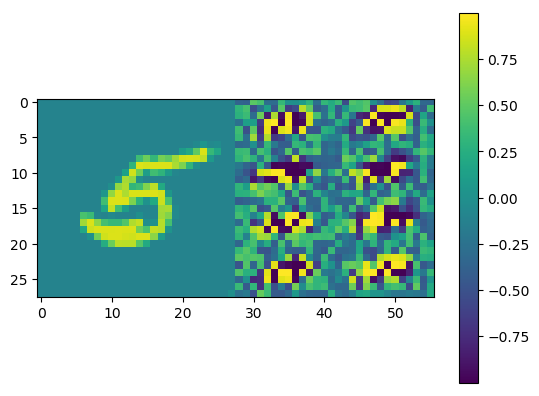

PyObject <matplotlib.colorbar.Colorbar object at 0x2b8e6d74bf60>

In [26]:
using PyPlot
ind=1090
image=reshape(train_representations[ind][1:784],(28,28))
image2=reshape(train_representations[ind][785:end],(28,28))
imshow(hcat(image',image2'))
colorbar()

In [20]:
test_representations = []
#for i in 1:size(x_test,1)
for i in 1:N_m
      test_rep, _ = neural_dynamics(network, x_test[i,:])
      #test_representations[i] = test_rep
      push!(test_representations,test_rep)
      if (i+1)%1000==0
          println(i+1)
      end
  end

1000
2000


In [21]:
classifier = SVC(max_iter=1e6, class_weight="balanced",tol=1e-5,random_state=0)

PyObject SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=1000000.0, probability=False, random_state=0, shrinking=True,
  tol=1e-05, verbose=False)

In [22]:
#fit!(clf, train_representations, y_train)
fit!(classifier, train_representations, y_train[1:N_m])

PyObject SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=1000000.0, probability=False, random_state=0, shrinking=True,
  tol=1e-05, verbose=False)

In [23]:
#train_score = score(clf, train_representations, y_train)
train_score = score(classifier, train_representations, y_train[1:N_m])
println("train_score")
println(train_score)

train_score
0.9225


In [24]:
for i in 1:length(test_representations)
    test_representations[i]=convert(Array{Float64,1},test_representations[i])
end

In [25]:
#test_score=score(clf,test_representations, y_test)
test_score=score(classifier,test_representations, y_test[1:N_m])
println("test_score")
println(test_score)

test_score
0.85
